In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [ ]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv')

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


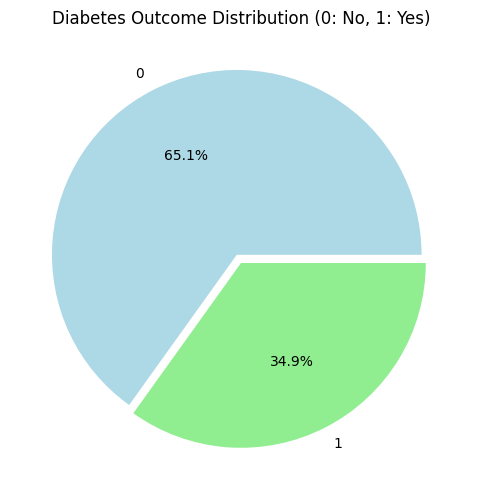

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.1f%%', colors=['lightblue', 'lightgreen'], explode=(0.05, 0))
plt.title('Diabetes Outcome Distribution (0: No, 1: Yes)')
plt.ylabel('')
plt.show()

In [ ]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
target_column = 'Outcome'
feature_columns = data.columns.drop(target_column).tolist()

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# 데이터와 타겟 분리
X = data[feature_columns].values
y = data[target_column].values

In [ ]:
# Split the dataset into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw) # Use transform only for test set

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [ ]:
# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

# 모델 정의

In [ ]:
# 모델 정의 (Dense Network)
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# Initialize the model
dense_model = DiabetesDense()

# 손실 함수 및 최적화 기법 정의

In [ ]:
# classification에 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_model.parameters(), lr=0.001)

# 모델 학습 (Dense Network)

In [ ]:
# Variables to store loss and accuracy
dense_train_losses = []
dense_test_accuracies = []
dense_all_labels_list = []
dense_all_predictions_list = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    dense_model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = dense_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # Multiply by batch size

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    dense_train_losses.append(epoch_loss)

    # Evaluate on test data
    dense_model.eval()
    correct = 0
    total = 0
    epoch_labels = []
    epoch_predictions = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = dense_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_labels.extend(labels.cpu().numpy())
            epoch_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    dense_test_accuracies.append(accuracy)
    # Store labels/predictions from the *last* epoch for final evaluation
    if epoch == num_epochs - 1:
        dense_all_labels = np.array(epoch_labels)
        dense_all_predictions = np.array(epoch_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Dense Network Training complete.")

Epoch 1/50, Loss: 0.6576, Accuracy: 73.38%
Epoch 2/50, Loss: 0.5799, Accuracy: 72.73%
Epoch 3/50, Loss: 0.5119, Accuracy: 70.78%
Epoch 4/50, Loss: 0.4815, Accuracy: 72.73%
Epoch 5/50, Loss: 0.4690, Accuracy: 72.08%
Epoch 6/50, Loss: 0.4598, Accuracy: 72.08%
Epoch 7/50, Loss: 0.4552, Accuracy: 71.43%
Epoch 8/50, Loss: 0.4514, Accuracy: 71.43%
Epoch 9/50, Loss: 0.4480, Accuracy: 71.43%
Epoch 10/50, Loss: 0.4455, Accuracy: 71.43%
Epoch 11/50, Loss: 0.4435, Accuracy: 71.43%
Epoch 12/50, Loss: 0.4426, Accuracy: 70.78%
Epoch 13/50, Loss: 0.4436, Accuracy: 71.43%
Epoch 14/50, Loss: 0.4346, Accuracy: 71.43%
Epoch 15/50, Loss: 0.4348, Accuracy: 70.78%
Epoch 16/50, Loss: 0.4301, Accuracy: 70.78%
Epoch 17/50, Loss: 0.4261, Accuracy: 72.08%
Epoch 18/50, Loss: 0.4250, Accuracy: 72.08%
Epoch 19/50, Loss: 0.4214, Accuracy: 72.08%
Epoch 20/50, Loss: 0.4203, Accuracy: 70.78%
Epoch 21/50, Loss: 0.4162, Accuracy: 72.08%
Epoch 22/50, Loss: 0.4155, Accuracy: 72.08%
Epoch 23/50, Loss: 0.4149, Accuracy: 73.3

# 모델 평가 (Dense Network)

In [ ]:
# Evaluation using metrics from the last epoch
conf_matrix = confusion_matrix(dense_all_labels, dense_all_predictions)
# Use average='weighted' for overall performance, or 'binary' for class 1 focus
f1 = f1_score(dense_all_labels, dense_all_predictions, average='weighted')
precision = precision_score(dense_all_labels, dense_all_predictions, average='weighted')
recall = recall_score(dense_all_labels, dense_all_predictions, average='weighted')

# Calculate specificity (True Negative Rate) for the negative class (0)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Specificity for class 0

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall (Sensitivity): {recall:.2f}') # Recall is also Sensitivity
print(f'Specificity: {specificity:.2f}')

Confusion Matrix:
[[77 23]
 [19 35]]
F1 Score: 0.73
Precision: 0.73
Recall (Sensitivity): 0.73
Specificity: 0.77


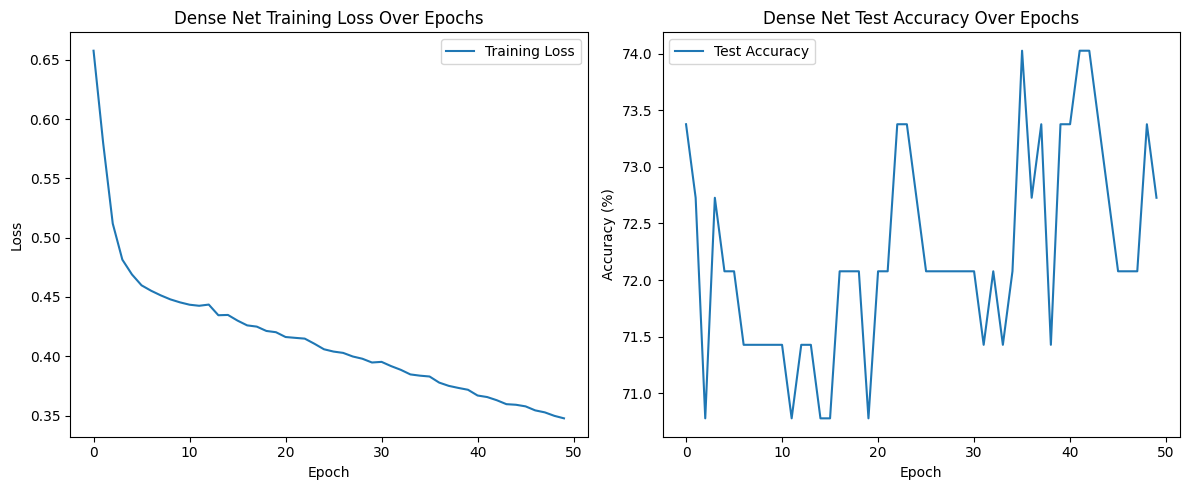

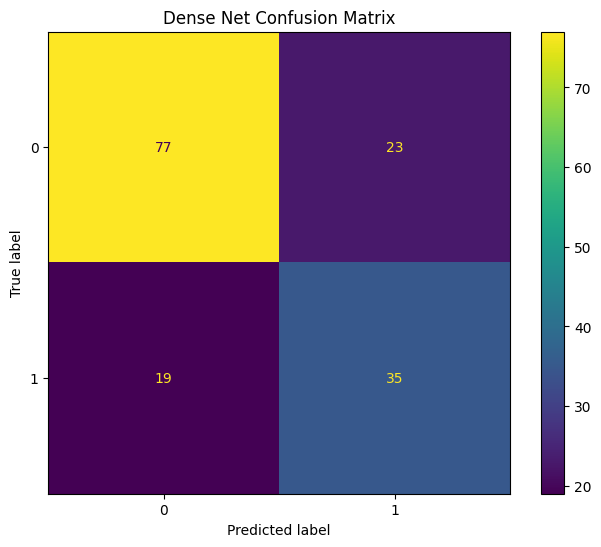

In [ ]:
# Plot the loss and accuracy for Dense Network
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(dense_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dense Net Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(dense_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Dense Net Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Dense Net Confusion Matrix')
plt.show()

In [ ]:
# 데이터와 타겟 분리
X = data[feature_columns].values
y = data[target_column].values

In [ ]:
# Standardize the features (using the whole dataset before splitting for sequence creation)
scaler_cnn = StandardScaler()
X_cnn_scaled = scaler_cnn.fit_transform(X)

In [ ]:
# Combine scaled features and target for sequence splitting
data_array = np.hstack((X_cnn_scaled, y.reshape(-1, 1)))

In [ ]:
data_array.shape

(768, 9)

In [ ]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the SEQUENCED dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((610, 5, 8), (610,), (153, 5, 8), (153,))

In [ ]:
# Convert sequenced data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64) # Use Long type
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader for sequenced data
batch_size_cnn = 32
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_cnn, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_cnn, shuffle=False)

In [ ]:
# 모델 정의 (1D CNN - Sequential 사용)
class DiabetesCNN(nn.Module):
    def __init__(self, n_features=8, n_steps=5, n_classes=2):
        super(DiabetesCNN, self).__init__()
        self.n_steps = n_steps
        self.n_features = n_features # 필요시 사용하기 위해 저장

        # Convolutional 레이어들을 Sequential로 묶음
        self.features = nn.Sequential(
            nn.Conv1d(n_features, 16, kernel_size=3, padding=1), # 입력 채널 = feature 수
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Classifier (Fully Connected) 레이어들을 Sequential로 묶음
        # Flattening은 forward 메서드에서 처리
        self.classifier = nn.Sequential(
            # 입력 크기는 마지막 Conv1d의 출력 채널 * 시퀀스 길이(n_steps)
            nn.Linear(32 * n_steps, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes) # 출력 크기 2 유지
        )

    def forward(self, x):
        # 학습 루프에서 permute(0, 2, 1)을 적용했다고 가정
        x = self.features(x)

        # Classifier에 입력하기 전에 Flatten 처리
        # x.view(batch_size, -1)와 동일
        x = x.view(x.size(0), -1)

        # Classifier 통과
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the CNN model, loss function, and optimizer
cnn_model = DiabetesCNN(n_features=X_train.shape[2], n_steps=n_steps, n_classes=2)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
# Print the summary of the CNN model
# Input size should be (features, sequence_length)
summary(cnn_model, input_size=(X_train.shape[2], n_steps))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
              ReLU-2                [-1, 16, 5]               0
            Conv1d-3                [-1, 32, 5]           1,568
              ReLU-4                [-1, 32, 5]               0
            Linear-5                   [-1, 64]          10,304
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 2]             130
Total params: 12,402
Trainable params: 12,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


# 모델 학습 (1D CNN)

In [ ]:
# Variables to store loss and accuracy for CNN
cnn_train_losses = []
cnn_test_accuracies = []
cnn_all_labels = []
cnn_all_predictions = []

In [ ]:
# Training loop for CNN
num_epochs_cnn = 50 # Can adjust epochs for CNN
for epoch in range(num_epochs_cnn):
    cnn_model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.permute(0, 2, 1)

        # Zero the parameter gradients
        cnn_optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(inputs)
        loss = cnn_criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        cnn_optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    cnn_train_losses.append(epoch_loss)

    # Evaluate on test data
    cnn_model.eval()
    correct = 0
    total = 0
    epoch_labels_cnn = []
    epoch_predictions_cnn = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.permute(0, 2, 1)

            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_labels_cnn.extend(labels.cpu().numpy())
            epoch_predictions_cnn.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    cnn_test_accuracies.append(accuracy)
    # Store labels/predictions from the *last* epoch for final evaluation
    if epoch == num_epochs_cnn - 1:
        cnn_all_labels = np.array(epoch_labels_cnn)
        cnn_all_predictions = np.array(epoch_predictions_cnn)

    print(f"CNN Epoch {epoch + 1}/{num_epochs_cnn}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("CNN Training complete.")

CNN Epoch 1/50, Loss: 0.6583, Accuracy: 65.36%
CNN Epoch 2/50, Loss: 0.6461, Accuracy: 65.36%
CNN Epoch 3/50, Loss: 0.6406, Accuracy: 65.36%
CNN Epoch 4/50, Loss: 0.6350, Accuracy: 65.36%
CNN Epoch 5/50, Loss: 0.6284, Accuracy: 65.36%
CNN Epoch 6/50, Loss: 0.6188, Accuracy: 64.05%
CNN Epoch 7/50, Loss: 0.6080, Accuracy: 65.36%
CNN Epoch 8/50, Loss: 0.5964, Accuracy: 65.36%
CNN Epoch 9/50, Loss: 0.5831, Accuracy: 64.05%
CNN Epoch 10/50, Loss: 0.5673, Accuracy: 60.78%
CNN Epoch 11/50, Loss: 0.5491, Accuracy: 56.86%
CNN Epoch 12/50, Loss: 0.5268, Accuracy: 56.86%
CNN Epoch 13/50, Loss: 0.5044, Accuracy: 53.59%
CNN Epoch 14/50, Loss: 0.4800, Accuracy: 56.86%
CNN Epoch 15/50, Loss: 0.4585, Accuracy: 49.02%
CNN Epoch 16/50, Loss: 0.4523, Accuracy: 55.56%
CNN Epoch 17/50, Loss: 0.4171, Accuracy: 54.90%
CNN Epoch 18/50, Loss: 0.3999, Accuracy: 50.98%
CNN Epoch 19/50, Loss: 0.3892, Accuracy: 54.90%
CNN Epoch 20/50, Loss: 0.3472, Accuracy: 56.21%
CNN Epoch 21/50, Loss: 0.3261, Accuracy: 56.86%
C


--- CNN Evaluation Results ---
Confusion Matrix:
[[61 39]
 [37 16]]
F1 Score: 0.51
Precision: 0.51
Recall (Sensitivity): 0.50
Specificity: 0.61


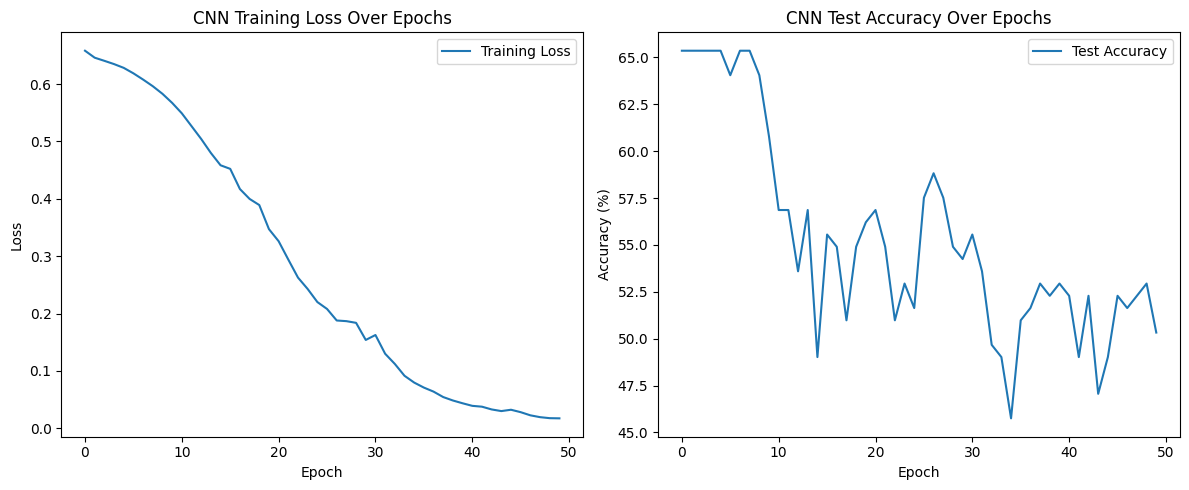

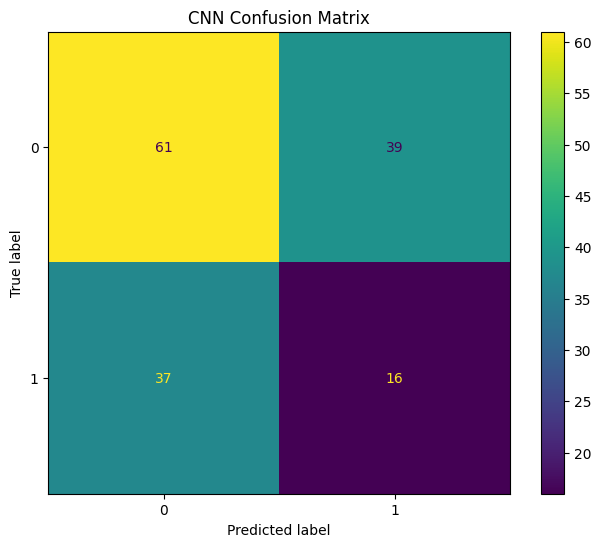

In [ ]:
# --- CNN Evaluation ---
# Calculate metrics for CNN
cnn_conf_matrix = confusion_matrix(cnn_all_labels, cnn_all_predictions)
cnn_f1 = f1_score(cnn_all_labels, cnn_all_predictions, average='weighted')
cnn_precision = precision_score(cnn_all_labels, cnn_all_predictions, average='weighted')
cnn_recall = recall_score(cnn_all_labels, cnn_all_predictions, average='weighted')

# Calculate specificity for CNN
cnn_tn, cnn_fp, cnn_fn, cnn_tp = cnn_conf_matrix.ravel()
cnn_specificity = cnn_tn / (cnn_tn + cnn_fp) if (cnn_tn + cnn_fp) > 0 else 0

# Print metrics for CNN
print("\n--- CNN Evaluation Results ---")
print(f'Confusion Matrix:\n{cnn_conf_matrix}')
print(f'F1 Score: {cnn_f1:.2f}')
print(f'Precision: {cnn_precision:.2f}')
print(f'Recall (Sensitivity): {cnn_recall:.2f}')
print(f'Specificity: {cnn_specificity:.2f}')

# Plot the loss and accuracy for CNN
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Display Confusion Matrix for CNN
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_conf_matrix)
cnn_disp.plot()
plt.title('CNN Confusion Matrix')
plt.show()